# Examining the Homeless Population of the United States
By Andrew Watkins

## Machine Learning

In [1]:
#Data Wrangling from previous section
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Name the files to use
file_hic_state = 'data/2007-2017-HIC-Counts-by-State.xlsx'
file_pit_state = 'data/2007-2017-PIT-Counts-by-State.xlsx'

# Load spreadsheet
hic_state = pd.ExcelFile(file_hic_state)
pit_state = pd.ExcelFile(file_pit_state)

#HIC
df_hic = pd.DataFrame()

#concat the rest of the sheets to the original df
for sheet in range(2007, 2018): 
    excel_sheet = hic_state.parse(str(sheet), header=1)
    excel_sheet['year'] = str(sheet)
    excel_sheet.set_index(['year','State'], inplace=True)
    df_hic = pd.concat([df_hic, excel_sheet], axis=0, ignore_index=False, sort=True)
    
#Columns were named differenlty before 2014 so we will use all the named variations and then combine them.
columns_to_use = [ "Total Year-Round Beds (ES)",
                   "Total Year-Round ES Beds",
                   "Total Year-Round Beds (TH)",
                   "Total Year-Round TH Beds",
                   "Total Year-Round Beds (SH)",
                   "Total Year-Round SH Beds",
                   "Total Year-Round Beds (PSH)",
                   "Total Year-Round PSH Beds",
                   "Total Year-Round Beds (RRH)",
                   "Total Year-Round RRH Beds",
                   "Total Year-Round Beds (DEM)",
                   "Total Year-Round Beds (OPH)",
]
df_hic = df_hic[columns_to_use]
df_hic.fillna(0.0, inplace=True)


#Here we combine the coumns that contain the same informaiton but were named differently. 
df_hic['Total Year-Round Beds (ES)'] = df_hic['Total Year-Round Beds (ES)'] + df_hic['Total Year-Round ES Beds']
df_hic['Total Year-Round Beds (TH)'] = df_hic['Total Year-Round Beds (TH)'] + df_hic['Total Year-Round TH Beds']
df_hic['Total Year-Round Beds (SH)'] = df_hic['Total Year-Round Beds (SH)'] + df_hic['Total Year-Round SH Beds']
df_hic['Total Year-Round Beds (PSH)'] = df_hic['Total Year-Round Beds (PSH)'] + df_hic['Total Year-Round PSH Beds']
df_hic['Total Year-Round Beds (RRH)'] = df_hic['Total Year-Round Beds (RRH)'] + df_hic['Total Year-Round RRH Beds']

#We drop the extra columns we no longer need.
cols_to_drop = ['Total Year-Round ES Beds',
                'Total Year-Round TH Beds',
                'Total Year-Round SH Beds',
                'Total Year-Round PSH Beds',
                'Total Year-Round RRH Beds']
df_hic.drop(cols_to_drop, axis=1, inplace=True)

#PIT
#Create a new DF with the rest of the sheets. Which are the homeless population in each state from 2007-2017
df_pit = pd.DataFrame()

#concat the rest of the sheets to the original df
for sheet in range(2007, 2018):
    excel_sheet = pit_state.parse(str(sheet))
    excel_sheet['year'] = str(sheet)
    excel_sheet.set_index(['year','State'], inplace=True)
    #rename the columns
    cols_to_use = []
    for column in excel_sheet.columns:
        if column.__contains__(','):
            cols_to_use.append(column.split(',')[0])
        else:
            cols_to_use.append(column)
    excel_sheet.columns = cols_to_use
    df_pit = pd.concat([df_pit, excel_sheet], axis=0, ignore_index=False, sort=True)
    
#There are only two with the note. So we just drop them directly. 
df_pit.drop(level=1, inplace=True, index='Note: The number of CoCs in 2016 was 402. However, MO-604 merged in 2016 and covers territory in both MO and KS, contributing to the PIT count in both states. ')
df_pit.drop(level=1, inplace=True, index='Note: The number of CoCs in 2017 was 399. However, MO-604 merged in 2016 and covers territory in both MO and KS, contributing to the PIT count in both states. ')

#Grab the 2 columns that we need for now
df_pit = df_pit[['Total Homeless', 'Number of CoCs']]
df_pit.fillna(0, inplace=True)
df_pit.replace(to_replace='.', value='0', inplace=True)
df_pit = df_pit.astype(float, copy=False)

#Merge both DF (PIT and HIC) and drop some unecessary columns
df = pd.concat([df_hic, df_pit], axis=1)
df.drop(index=['Total', 'KS*', ' ', 'MP'], level=1, inplace=True)

#Create an aggregate column of the total of all the beds.
df['Total Beds'] = df_hic['Total Year-Round Beds (ES)'] + df_hic['Total Year-Round Beds (TH)'] + df_hic['Total Year-Round Beds (SH)'] + df_hic['Total Year-Round Beds (PSH)'] + df_hic['Total Year-Round Beds (RRH)'] + df_hic['Total Year-Round Beds (DEM)'] + df_hic['Total Year-Round Beds (OPH)']
df.fillna(0, inplace=True)

ML Models
-Linear Regression
-Logistic Regression (How to divide/classify the total amount of beds?)
-Decision Tree
-SVM
-Naive Bayes
-K-Means
-Random Forests

# Section:  Linear Regression

In [2]:
#additional imports needed for ML
from sklearn.model_selection import train_test_split

In [3]:
#We now need to create a train-test split in our data that we will use on all our models.
X=df['Total Homeless'].values.reshape(-1,1)
y=df['Total Beds'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [4]:
#drop CA and NY
df_min = df.drop(index=['CA', 'NY'], level=1)

#We now need to create a train-test split in our data that we will use on all our models.
X_min=df_min['Total Homeless'].values.reshape(-1,1)
y_min=df_min['Total Beds'].values.reshape(-1,1)

X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(X_min, y_min, test_size = 0.2, random_state=42)

## Linear Regression

In [5]:
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from patsy.builtins import *

In [6]:
# Create linear regression object
model = linear_model.LinearRegression()

# Train the model using the training sets and check score
model.fit(X_train, y_train)

#Predict Output
y_pred = model.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(model.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.8942869051025861
Root Mean Squared Error: 5203.300913404745


In [7]:
model = ols("Q('Total Homeless') ~ Q('Total Beds')", df).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     Q('Total Homeless')   R-squared:                       0.820
Model:                             OLS   Adj. R-squared:                  0.820
Method:                  Least Squares   F-statistic:                     2696.
Date:                 Thu, 07 Mar 2019   Prob (F-statistic):          1.37e-222
Time:                         14:07:14   Log-Likelihood:                -6211.8
No. Observations:                  594   AIC:                         1.243e+04
Df Residuals:                      592   BIC:                         1.244e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1054.4702    41

 
 
### We now do the same operations with the min df.
 
 

In [8]:
# Create linear regression object
model = linear_model.LinearRegression()

# Train the model using the training sets and check score
model.fit(X_train_min, y_train_min)

#Predict Output
y_pred_min = model.predict(X_test_min)

# Compute and print R^2 and RMSE
print("R^2: {}".format(model.score(X_test_min, y_test_min)))
rmse_min = np.sqrt(mean_squared_error(y_test_min, y_pred_min))
print("Root Mean Squared Error: {}".format(rmse_min))

R^2: 0.6921948861246401
Root Mean Squared Error: 5248.060219215974


In [9]:
model = ols("Q('Total Homeless') ~ Q('Total Beds')", df_min).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     Q('Total Homeless')   R-squared:                       0.665
Model:                             OLS   Adj. R-squared:                  0.665
Method:                  Least Squares   F-statistic:                     1134.
Date:                 Thu, 07 Mar 2019   Prob (F-statistic):          1.18e-137
Time:                         14:07:14   Log-Likelihood:                -5678.6
No. Observations:                  572   AIC:                         1.136e+04
Df Residuals:                      570   BIC:                         1.137e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         341.0452    30

## Decission Tree

In [10]:
#Import Library
from sklearn import tree
from sklearn.metrics import accuracy_score

In [11]:
# Create tree object 
model = tree.DecisionTreeRegressor() #for regression

#Train the model using the training sets and check score
model.fit(X_train, y_train)

#Predict Output
y_pred= model.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(model.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.7557748670573805
Root Mean Squared Error: 7908.784208559684


In [12]:
# Create tree object 
model = tree.DecisionTreeRegressor()

#Train the model using the training sets and check score
model.fit(X_train_min, y_train_min)

#Predict Output
y_pred_min = model.predict(X_test_min)

# Compute and print R^2 and RMSE
print("R^2: {}".format(model.score(X_test_min, y_test_min)))
rmse = np.sqrt(mean_squared_error(y_test_min, y_pred_min))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.5423021831180048
Root Mean Squared Error: 6399.562940239509


## KNN

In [13]:
#Import Library
from sklearn.neighbors import KNeighborsClassifier

In [14]:
# Create KNeighbors classifier object model 
model = KNeighborsClassifier(n_neighbors=6) # default value for n_neighbors is 5

# Train the model using the training sets and check score
model.fit(X_train, y_train.ravel())

#Predict Output
predicted= model.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(model.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.0
Root Mean Squared Error: 7908.784208559684


WHat threshold or category should I create?

In [15]:
# Create KNeighbors classifier object model 
model = KNeighborsClassifier(n_neighbors=6) # default value for n_neighbors is 5

# Train the model using the training sets and check score
model.fit(X_train_min, y_train_min.ravel())

#Predict Output
y_pred = model.predict(X_test_min)

# Compute and print R^2 and RMSE
print("R^2: {}".format(model.score(X_test_min, y_test_min)))
rmse = np.sqrt(mean_squared_error(y_test_min, y_pred_min))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.0
Root Mean Squared Error: 6399.562940239509


## Random Forest

In [16]:
#Import Library
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [17]:
# Create Random Forest object
model = RandomForestClassifier()

# Train the model using the training sets and check score
model.fit(X_train, y_train.ravel())

#Predict Output
y_pred = model.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(model.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.0
Root Mean Squared Error: 7949.807465561402


In [18]:
# Create Random Forest object
model = RandomForestClassifier()

# Train the model using the training sets and check score
model.fit(X_train_min, y_train_min.ravel())

#Predict Output
y_pred = model.predict(X_test_min)

# Compute and print R^2 and RMSE
print("R^2: {}".format(model.score(X_test_min, y_test_min)))
rmse = np.sqrt(mean_squared_error(y_test_min, y_pred_min))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.008695652173913044
Root Mean Squared Error: 6399.562940239509


# Section: Logistic Regression

In this section we will use logistic regression to classify the states. However we don't have any columns we can use to classify them. So in order to be able to do some logistic regression we need to create or determine a threshold for our data to be able to determine if the threshold is met and add it as a column. The threshold we are going to add is called 'Able', we are going to classify if the state is able to handle their homeless popualtion based on the bed to homeless ratio. We will plot the distribution of the home to bed ratio and determine what threshold we will use to determine if a state is 'able'.

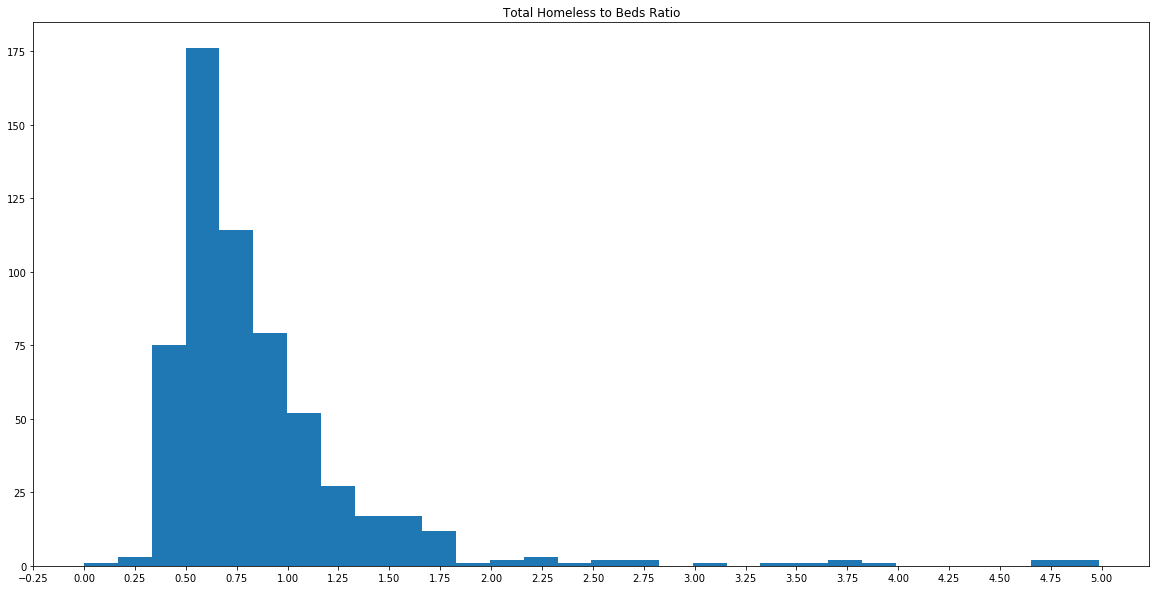

In [19]:
#We plot the of the homeless vs the beds in a scatter plot
import matplotlib.ticker
fig, ax = plt.subplots(figsize=(20,10))
plt.hist(x=(df['Total Homeless']/df['Total Beds']), bins=30)
plt.title('Total Homeless to Beds Ratio')
plt.xticks(range(5))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.25))
plt.show()

Based on the distribution we will use anything above .25 as 'able'.

In [50]:
#create a new column called 'Able', a boolean value which determines if the ratio of homeless to beds is above .25
df['Able'] = df['Total Homeless']/df['Total Beds'] > 0.50
df.head()

Total Year-Round Beds (ES)  Total Year-Round Beds (TH)  \
year State                                                           
2007 AK                         1095.0                       663.0   
     AL                         1766.0                      2607.0   
     AR                         1483.0                      1109.0   
     AZ                         3736.0                      5597.0   
     CA                        20181.0                     30897.0   

            Total Year-Round Beds (SH)  Total Year-Round Beds (PSH)  \
year State                                                            
2007 AK                            0.0                        489.0   
     AL                            0.0                       2420.0   
     AR                            0.0                       1538.0   
     AZ                            0.0                       3019.0   
     CA                            0.0                      26787.0   

            Total Year-Round Beds (RRH)  Total Year-Round Beds (DEM)  \
year State                                                             
2007 AK                             0.0                          0.0   
     AL                             0.0                          0.0   
     AR                             0.0                          0.0   
     AZ                             0.0                          0.0   
     CA                             0.0                          0.0   

            Total Year-Round Beds (OPH)  Total Homeless  Number of CoCs  \
year State                                                                
2007 AK                             0.0          1642.0             2.0   
     AL                             0.0          5452.0             8.0   
     AR                             0.0          3836.0             9.0   
     AZ                             0.0         14646.0             3.0   
     CA                             0.0        138986.0            42.0   

            Total Beds  Able  
year State                    
2007 AK         2247.0  True  
     AL         6793.0  True  
     AR         4130.0  True  
     AZ        12352.0  True  
     CA        77865.0  True

In [51]:
#We now need to create a train-test split in our data that we will use on all our models.
#X=df[['Total Year-Round Beds (ES)','Total Year-Round Beds (TH)','Total Year-Round Beds (SH)','Total Year-Round Beds (PSH)','Total Year-Round Beds (RRH)','Total Year-Round Beds (DEM)','Total Year-Round Beds (OPH)']]#.values.reshape(-1,1)
#y=df['Total Beds']#.values.reshape(-1,1)
X=df
y=df['Able']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, shuffle=False)

## Logistic Regression

In [54]:
#Import Library
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

In [55]:
# Create logistic regression object
model = LogisticRegression()

# Train the model using the training sets and check score
model.fit(X_train, y_train)

#Predict Output
y_pred = model.predict(X_test)

#Print Accuracy
print('Accuracy: ', accuracy_score(y_pred, y_test))

Accuracy:  1.0


In [56]:
print(y_pred)

[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False  True  True  True  True  True
  True  True False  True  True  True False  True False False False False
 False  True  True  True  True  True  True  True False  True  True False
  True  True False  True False  True  True  True  True False False  True
  True  True  True False  True  True  True  True  True  True  True False
 False False  True  True  True  True  True  True False  True False  True
 False False False False False False False  True  True  True  True  True
  True  True False  True  True False  True  True False  True False  True
 False  True  True False False  True  True  True False False  True]


## KNN

In [57]:
#Import Library
from sklearn.neighbors import KNeighborsClassifier

In [58]:
# Create KNeighbors classifier object model 
model = KNeighborsClassifier(n_neighbors=6) # default value for n_neighbors is 5

# Train the model using the training sets and check score
model.fit(X_train, y_train)

#Predict Output
y_pred = model.predict(X_test)

#Print Accuracy
print('Accuracy: ', accuracy_score(y_pred, y_test))

Accuracy:  0.8151260504201681


## K-Means

In [59]:
#Import Library
from sklearn.cluster import KMeans

In [72]:
# Create KNeighbors classifier object model 
model = KMeans(n_clusters=1)

# Train the model using the training sets and check score
model.fit(X_train)

#Predict Output
y_pred = model.predict(X_test)

#Print Accuracy
print('Accuracy: ', accuracy_score(y_pred, y_test))

Accuracy:  0.31932773109243695


## Descision Tree

In [61]:
# Create tree object 
model = tree.DecisionTreeRegressor() #for regression

#Train the model using the training sets and check score
model.fit(X_train, y_train)

#Predict Output
y_pred= model.predict(X_test)

#Print Accuracy
print('Accuracy: ', accuracy_score(y_pred, y_test))

Accuracy:  1.0


## SVM

In [62]:
#Import Library
from sklearn import svm

In [63]:
# Create SVM classification object 
model = svm.SVC()

# Train the model using the training sets and check score
model.fit(X_train, y_train)

#Predict Output
predicted= model.predict(X_test)

#Print Accuracy
print('Accuracy: ', accuracy_score(y_pred, y_test))

Accuracy:  1.0


## Naive Bayes

In [64]:
#Import Library
from sklearn.naive_bayes import GaussianNB

In [65]:
# Create SVM classification object 
model = GaussianNB()

# Train the model using the training sets and check score
model.fit(X_train, y_train)

#Predict Output
y_pred= model.predict(X_test)

#Print Accuracy
print('Accuracy: ', accuracy_score(y_pred, y_test))

Accuracy:  0.7983193277310925


## Random Forest

In [66]:
# Create Random Forest object
model = RandomForestClassifier()

# Train the model using the training sets and check score
model.fit(X_train, y_train)

#Predict Output
y_pred = model.predict(X_test)

#Print Accuracy
print('Accuracy: ', accuracy_score(y_pred, y_test))

Accuracy:  1.0
